In [15]:
from agents.state import MessageState
from node_and_edge.context_node import context_node
from node_and_edge.sys_msg_node import sys_msg_node
from node_and_edge.assistant_node import assistant_node
from node_and_edge.sql_note import sql_query_node
from node_and_edge.sql_verify_edge import sql_verify_edge
from node_and_edge.show import show
from langgraph.graph import StateGraph,START,END

In [23]:
state = MessageState()
state['question'] = "Cho tôi GMV theo từng tháng trong toàn bộ dữ liệu, kèm tỷ lệ tăng trưởng MoM và YoY cho mỗi tháng; sắp xếp theo thời gian để thấy xu hướng. hiển thị các tên trường bày tiếng Việt thay vì tiếng anh cho tôi hiểu"

In [24]:
graph = StateGraph(MessageState)

graph.add_node("context_node",context_node)
graph.add_node("sys_msg_node", sys_msg_node)
graph.add_node("assistant_node", assistant_node)
graph.add_node("sql_query_node",sql_query_node)
graph.add_node("show", show)

graph.add_edge(START, "context_node")
graph.add_edge("context_node", "sys_msg_node")
graph.add_edge("sys_msg_node", "assistant_node")
graph.add_edge("assistant_node", "sql_query_node")
graph.add_conditional_edges("sql_query_node", sql_verify_edge)
graph.add_edge("show", END)

# graph.add_edge("sql_query_node", END)
app = graph.compile()

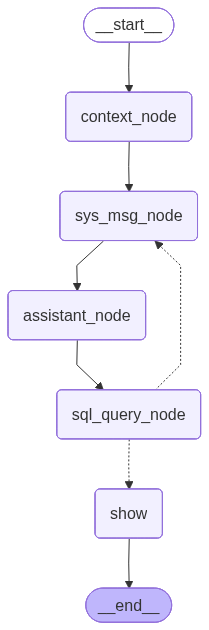

In [25]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
state = app.invoke(state)

In [27]:
state

{'SQL_format': 'postgres',
 'question': 'Cho tôi GMV theo từng tháng trong toàn bộ dữ liệu, kèm tỷ lệ tăng trưởng MoM và YoY cho mỗi tháng; sắp xếp theo thời gian để thấy xu hướng. hiển thị các tên trường bày tiếng Việt thay vì tiếng anh cho tôi hiểu',
 'system_msg': "Bạn là chuyên gia viết SQL {postgres} để trả lời câu hỏi tiếng Việt/Anh dựa trên mô tả cơ sở dữ liệu cung cấp.\n\nQUY TẮC BẮT BUỘC:\n1) Chỉ tạo câu lệnh SELECT hợp lệ cho {postgres}; không được tạo DDL/DML.\n2) Luôn ghi rõ schema trước tên bảng (schema.table). Không tự suy ra bảng/cột không có trong mô tả.\n3) Ưu tiên cột/khóa có trong mô tả. Nếu thiếu thông tin, dùng comment ngắn dạng -- TODO:<vấn đề>.\n4) Mặc định giới hạn kết quả để an toàn:\n   - postgres/mysql: dùng LIMIT 200.\n   - mssql: dùng TOP 200 hoặc OFFSET…FETCH (nếu có ORDER BY).\n5) Đặt alias cột ngắn gọn, snake_case; tránh khoảng trắng; không dùng dấu tiếng Việt trong alias.\n6) Đối với lọc thời gian mơ hồ như “gần đây”, hiểu là 6 tháng gần nhất.\n7) Xử lý

In [37]:
sql = state["SQL_statement"]

In [40]:
import pprint
pprint.pprint(sql)

('SELECT \n'
 "    TO_CHAR(DATE_TRUNC('month', o.order_purchase_timestamp), 'YYYY-MM') AS "
 '"Tháng",\n'
 '    COALESCE(SUM(oi.price), 0) AS "GMV",\n'
 "    LAG(COALESCE(SUM(oi.price), 0)) OVER (ORDER BY DATE_TRUNC('month', "
 'o.order_purchase_timestamp)) AS "GMV_tháng_trước",\n'
 '    ROUND(\n'
 '        CASE \n'
 '            WHEN LAG(COALESCE(SUM(oi.price), 0)) OVER (ORDER BY '
 "DATE_TRUNC('month', o.order_purchase_timestamp)) > 0 \n"
 '            THEN \n'
 '                100.0 * (COALESCE(SUM(oi.price), 0) - '
 "LAG(COALESCE(SUM(oi.price), 0)) OVER (ORDER BY DATE_TRUNC('month', "
 'o.order_purchase_timestamp))) / LAG(COALESCE(SUM(oi.price), 0)) OVER (ORDER '
 "BY DATE_TRUNC('month', o.order_purchase_timestamp))\n"
 '            ELSE 0 \n'
 '        END, 2\n'
 '    ) AS "Tăng_trưởng_MoM",\n'
 "    LAG(COALESCE(SUM(oi.price), 0), 12) OVER (ORDER BY DATE_TRUNC('month', "
 'o.order_purchase_timestamp)) AS "GMV_năm_trước",\n'
 '    ROUND(\n'
 '        CASE \n'
 '            WHEN L

In [32]:
data = state["SQL_data_results"]

In [34]:
print(type(data))

<class 'list'>


In [35]:
import pandas as pd

df = pd.DataFrame(data=data)

In [36]:
df

,0,1,2,3,4,5
0,2016-09,207.86,None,0.00,None,0.00
1,2016-10,41234.67,207.86,19737.71,None,0.00
2,2016-12,10.90,41234.67,-99.97,None,0.00
3,2017-01,114197.09,10.90,1047579.72,None,0.00
4,2017-02,237994.76,114197.09,108.41,None,0.00
5,2017-03,362912.17,237994.76,52.49,None,0.00
6,2017-04,345999.86,362912.17,-4.66,None,0.00
7,2017-05,497190.99,345999.86,43.70,None,0.00
8,2017-06,426699.11,497190.99,-14.18,None,0.00
9,2017-07,488961.75,426699.11,14.59,None,0.00
